In [1]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import logging
# Set logging level to suppress warnings
logging.basicConfig(level=logging.ERROR)

In [3]:
# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

df.head()

/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_25770/3691372692.py:2: DtypeWarning: Columns (1,10,18,21,22,24,25,26,27,28,33,35,39,44,45,46,203,205,207) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,B,Br,Cl,K,Sr,Na,Li
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98


In [4]:
bins = [0, 70, 200, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=True)
df.head()

,B,Br,Cl,K,Sr,Na,Li,Li_class
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50,low
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30,low
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98,low
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10,low
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98,low


In [5]:
# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)
df.head()

,B,Br,Cl,K,Sr,Na,Li,Li_class
265,5.2,2.20,1144.0,36.0,1.60,853.0,1.50,0
329,48.0,1.50,877.0,65.0,0.67,662.0,1.30,0
342,11.8,0.53,223.0,22.0,0.14,168.0,1.98,0
344,41.8,1.46,853.0,64.0,0.48,690.0,6.10,0
347,41.3,1.40,843.0,80.0,0.52,672.0,6.98,0


In [6]:
# Preserve the Na_class for later (it must stay based on the original 'Na' values)
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Li' and 'Li_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na']].apply(np.log10)

# Reassign 'Na_class' back to the dataframe to keep it intact
df['Li_class'] = li_class

# Drop 'Na' column since it's no longer needed
df = df.drop(columns='Li')
original_df = original_df.drop(columns=['Li_class'])

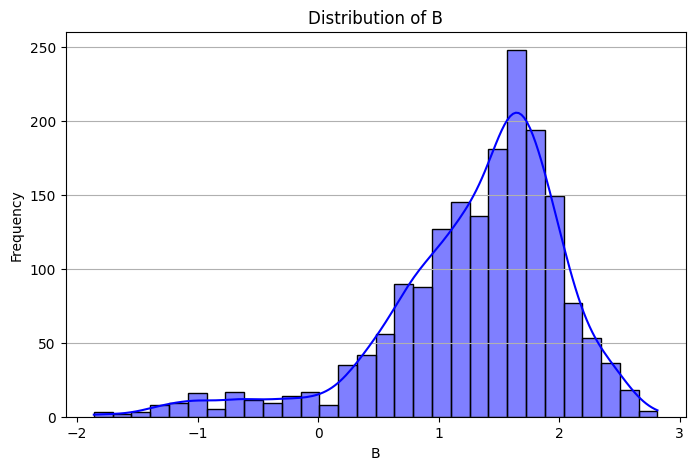

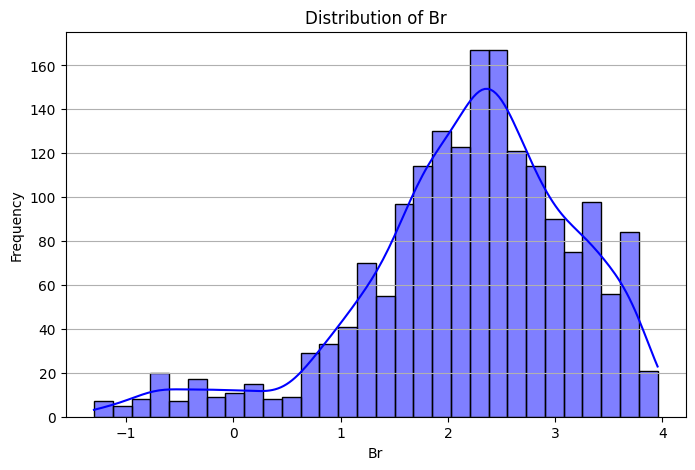

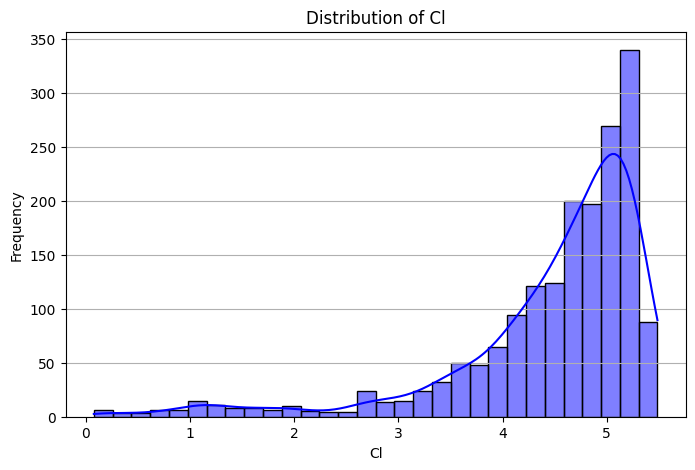

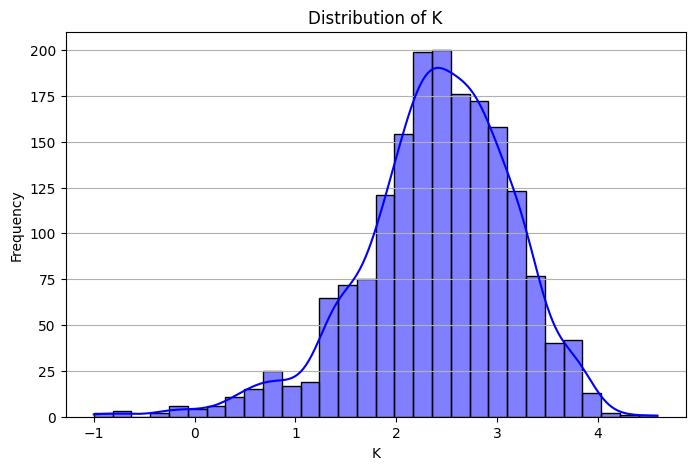

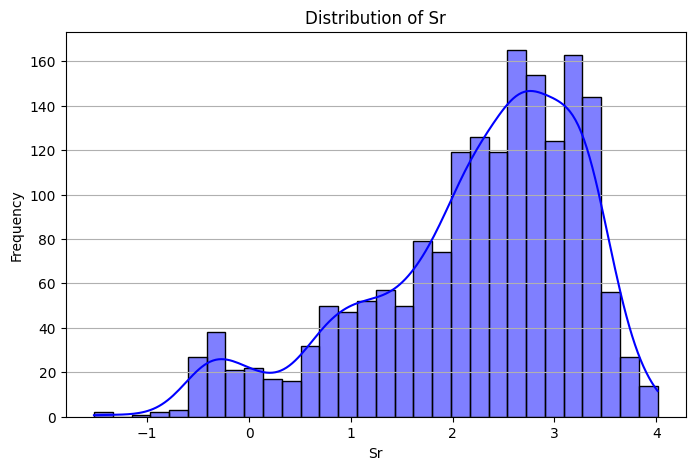

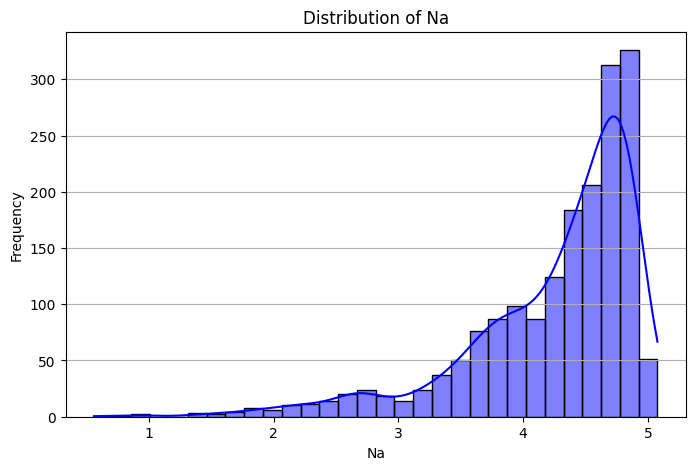

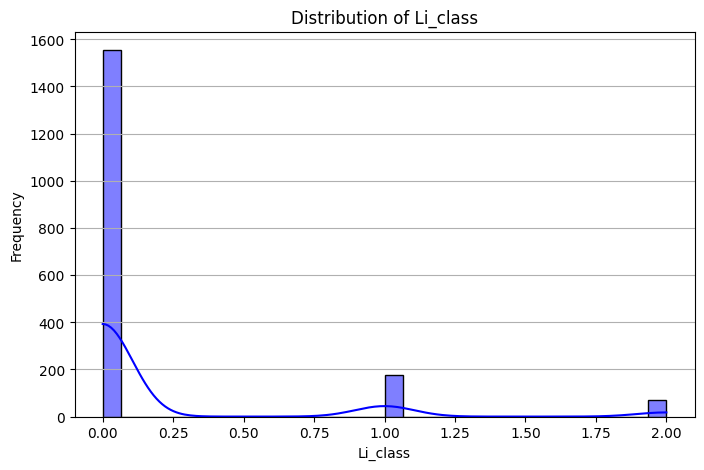

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(dataframe):
    for column in dataframe.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataframe[column], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y')
        plt.show()

plot_distributions(df)

Li_class
0    1555
1     176
2      70
Name: count, dtype: int64


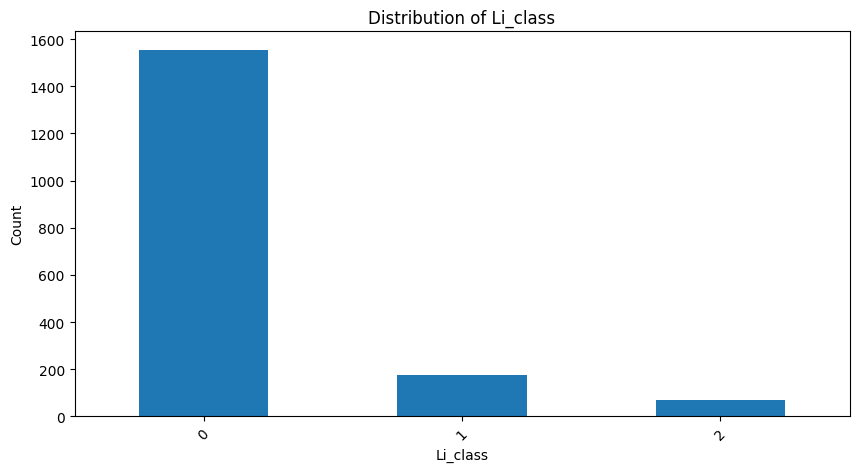

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv("your_data.csv")

# Count occurrences of each class
class_counts = df['Li_class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.xlabel("Li_class")
plt.ylabel("Count")
plt.title("Distribution of Li_class")
plt.xticks(rotation=45)
plt.show()


In [9]:
!pip install ImbalancedDatasetSampler

ERROR: Could not find a version that satisfies the requirement ImbalancedDatasetSampler (from versions: none)
ERROR: No matching distribution found for ImbalancedDatasetSampler


In [10]:
from torchsampler import ImbalancedDatasetSampler
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

In [11]:
from torch.utils.data import Dataset
from torchsampler import ImbalancedDatasetSampler
import torch

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = df.drop('Li_class', axis=1).values
        self.labels = df['Li_class'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

    def get_labels(self):
        return self.labels

custom_dataset = CustomDataset(df)

In [12]:
from torch.utils.data import DataLoader

sampler = ImbalancedDatasetSampler(custom_dataset)
balanced_loader = DataLoader(custom_dataset, sampler=sampler, batch_size=len(custom_dataset))

In [13]:
balanced_data = next(iter(balanced_loader))
balanced_labels = balanced_data[1].numpy()

class_distribution_after = pd.Series(balanced_labels).value_counts(normalize=True)
print("Class Distribution After Sampling:")
print(class_distribution_after)


Class Distribution After Sampling:
1    0.340366
2    0.334814
0    0.324820
Name: proportion, dtype: float64


In [14]:
# Extract the entire resampled dataset
for batch in balanced_loader:
    features, labels = batch
    break  # since we only need one batch which contains the entire dataset

# Convert tensors to numpy arrays
features_np = features.numpy()
labels_np = labels.numpy()

# Define feature names
feature_names = ['B', 'Br', 'Cl', 'K', 'Sr', 'Na']

# Create a DataFrame for features
features_df = pd.DataFrame(features_np, columns=feature_names)

# Create a DataFrame for labels
labels_df = pd.DataFrame(labels_np, columns=['Li_class'])

# Combine features and labels into a single DataFrame
resampled_df = pd.concat([features_df, labels_df], axis=1)


In [15]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   B         1801 non-null   float32
 1   Br        1801 non-null   float32
 2   Cl        1801 non-null   float32
 3   K         1801 non-null   float32
 4   Sr        1801 non-null   float32
 5   Na        1801 non-null   float32
 6   Li_class  1801 non-null   int64  
dtypes: float32(6), int64(1)
memory usage: 56.4 KB


In [16]:
resampled_df.head()

,B,Br,Cl,K,Sr,Na,Li_class
0,2.079181,2.597695,5.011570,3.314920,3.385427,4.669038,1
1,0.720986,2.252853,4.870989,2.568202,2.344392,4.627366,0
2,1.719331,3.432809,5.323339,3.159266,3.129690,4.817208,1
3,2.553883,3.631038,5.247185,3.851258,3.353724,4.860338,2
4,1.230449,0.770852,3.513084,1.995635,1.755875,3.130655,0


In [17]:
X_resampled = resampled_df.drop(columns='Li_class')
y_resampled = resampled_df['Li_class']

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=259, stratify=y_resampled
)

# ================================
# 2. Model Training and Evaluation
# ================================

# 2.1 Define the classifiers with default parameters
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=259),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=259),
    'LightGBM': LGBMClassifier(random_state=259),
    'ExtraTrees': ExtraTreesClassifier(random_state=259),
    'GradientBoosting': GradientBoostingClassifier(random_state=259)
}

# 2.2 Create dictionaries to store the results
results = {}
cv_results = {}

# 2.3 Define a function to train and evaluate each model
def train_and_evaluate_model(clf_name, clf, X_train, y_train):
    print(f"\nTraining {clf_name}...")
    try:
        # Record start time
        start_time = time.time()

        # Train the model with default parameters
        clf.fit(X_train, y_train)

        # Perform 5-fold cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        accuracy_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        precision_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='precision_weighted')
        recall_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall_weighted')
        f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')

        # Calculate the metrics
        accuracy = accuracy_scores.mean()
        precision_mean = precision_scores.mean()
        recall_mean = recall_scores.mean()
        f1_mean = f1_scores.mean()

        # Record end time
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Store the overall results
        results[clf_name] = {
            'Accuracy': accuracy,
            'Precision': precision_mean,
            'Recall': recall_mean,
            'F1-Score': f1_mean,
            'Time (s)': elapsed_time,
            'Best Parameters': "Default"
        }

        # Store the detailed 5-fold CV results
        cv_results[clf_name] = pd.DataFrame({
            'Fold': range(1, 6),
            'Accuracy': accuracy_scores,
            'Precision': precision_scores,
            'Recall': recall_scores,
            'F1-Score': f1_scores
        })

        # Save the model as a .pkl file
        dump(clf, f'results-withlog/{clf_name}_model.pkl')

        print(f"{clf_name} trained successfully in {elapsed_time:.2f} seconds.")

    except Exception as e:
        print(f"Error occurred with {clf_name}: {e}")

# 2.4 Loop through classifiers and train/evaluate each model
for clf_name, clf in classifiers.items():
    train_and_evaluate_model(clf_name, clf, X_train, y_train)

# 2.5 Check if results are collected
if not results:
    print("No results were collected. Check for errors during model training.")

# 2.6 Save the overall results to a CSV file with model names as index
results_df = pd.DataFrame(results).T  # Transpose to have model names as rows
results_df.to_csv('results-withlog/model_metrics.csv', index=True)

# 2.7 Save the detailed 5-fold CV metrics to separate CSV files
for clf_name, df in cv_results.items():
    df.to_csv(f'results-withlog/{clf_name}_cv_metrics.csv', index=False)

# ================================
# 3. Evaluation on Validation Set
# ================================

# 3.1 Evaluate the models on the validation dataset
test_results = {}

for clf_name in classifiers.keys():
    try:
        clf = load(f'results-withlog/{clf_name}_model.pkl')
        y_pred = clf.predict(X_val)

        # Calculate test metrics
        test_accuracy = accuracy_score(y_val, y_pred)
        test_precision = precision_score(y_val, y_pred, average='weighted')
        test_recall = recall_score(y_val, y_pred, average='weighted')
        test_f1 = f1_score(y_val, y_pred, average='weighted')

        # Store the test metrics
        test_results[clf_name] = {
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1-Score': test_f1
        }

    except Exception as e:
        print(f"Error occurred during test evaluation for {clf_name}: {e}")

# 3.2 Save the test results to a CSV file with model names as index
test_results_df = pd.DataFrame(test_results).T  # Transpose to have model names as rows
test_results_df.to_csv('results-withlog/test_metrics.csv', index=True)

# 3.3 Print the test results
for clf_name, metrics in test_results.items():
    print(f"\n{clf_name} Test Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# ================================
# 4. Ranking Models
# ================================

# 4.1 Convert the results dictionary to a DataFrame and ensure model names are included
results_df = pd.DataFrame(results).T  # Transpose to have model names as rows
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model Name'}, inplace=True)

# 4.2 Add custom rank calculation and sorting
# The custom rank is a weighted sum of accuracy and inverse of training time
# Adjust the weights as needed
results_df['Custom Rank'] = 0.8 * results_df['Accuracy'] + 0.2 * (60 / results_df['Time (s)'])

# Handle potential division by zero in Custom Rank
results_df['Custom Rank'].replace([np.inf, -np.inf], 0, inplace=True)

# Sort the models based on the custom rank, with the highest rank first
ranked_results_df = results_df.sort_values(by='Custom Rank', ascending=False).reset_index(drop=True)

# Update the Rank column based on the new ordering
ranked_results_df['Rank'] = ranked_results_df.index + 1

# Display the updated metrics DataFrame with ranking
print("\nRanked Model Metrics:")
print(ranked_results_df[['Rank', 'Model Name', 'Accuracy', 'Time (s)', 'Custom Rank']].head(5))

# 4.3 Save the ranked results to a CSV file
ranked_results_df.to_csv('results-withlog/ranked_model_metrics.csv', index=False)


Training RandomForest...
RandomForest trained successfully in 2.29 seconds.

Training XGBoost...
XGBoost trained successfully in 3.32 seconds.

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 6
[LightGBM] [Info] Start training from score -1.069863
[LightGBM] [Info] Start training from score -1.067841
[LightGBM] [Info] Start training from score -1.160931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points

/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_25770/709882427.py:150: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['Custom Rank'].replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_25770/709882427.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_si

In [18]:
resampled_df.columns

Index(['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li_class'], dtype='object')

## Extra Trees Robustness Tests

In [29]:
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import HopSkipJump

data = resampled_df

# Split into features and target
X = data[['B', 'Br', 'Cl', 'K', 'Sr', 'Na']]
y = data['Li_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to numpy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Initialize and train the model
model = ExtraTreesClassifier()
model.fit(X_train_np, y_train_np)

# Convert XGBoost model to ART classifier
art_model = SklearnClassifier(model=model)

In [30]:
from art.attacks.evasion import HopSkipJump
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np
import xgboost as xgb

# Set up the HopSkipJump attack
attack = HopSkipJump(
    classifier=art_model,
    batch_size=4,
    targeted=False,
    norm=2,
    max_iter=1,  # Increase to allow more iterations
    max_eval=1,  # Increase to allow more evaluations
    init_eval=1,  # Increase for more initial evaluations
    init_size=1,  # Increase for more trials in initial generation
    verbose=True
)

# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
precision_defended, recall_defended, f1_defended, _ = precision_recall_fscore_support(y_test_np, y_pred_defended, average="weighted")
print(f"\nMetrics after defense:")
print(f"Accuracy: {accuracy_defended:.6f}")
print(f"Precision: {precision_defended:.6f}")
print(f"Recall: {recall_defended:.6f}")
print(f"F1-Score: {f1_defended:.6f}")
print(classification_report(y_test_np, y_pred_defended))


HopSkipJump: 100%|██████████████████████████████████████| 541/541 [00:12<00:00, 42.21it/s]


Metrics after attack:
Accuracy: 0.332717
Precision: 0.157803
Recall: 0.332717
F1-Score: 0.212458
              precision    recall  f1-score   support

           0       0.46      0.99      0.63       178
           1       0.02      0.01      0.02       202
           2       0.00      0.00      0.00       161

    accuracy                           0.33       541
   macro avg       0.16      0.34      0.21       541
weighted avg       0.16      0.33      0.21       541


Metrics after defense:
Accuracy: 0.985213
Precision: 0.985521
Recall: 0.985213
F1-Score: 0.985194
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       178
           1       0.97      1.00      0.98       202
           2       1.00      1.00      1.00       161

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



Accuracy after defense: 0.9870609981515711
Classification Report after defense:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       178
           1       0.97      1.00      0.98       202
           2       1.00      1.00      1.00       161

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



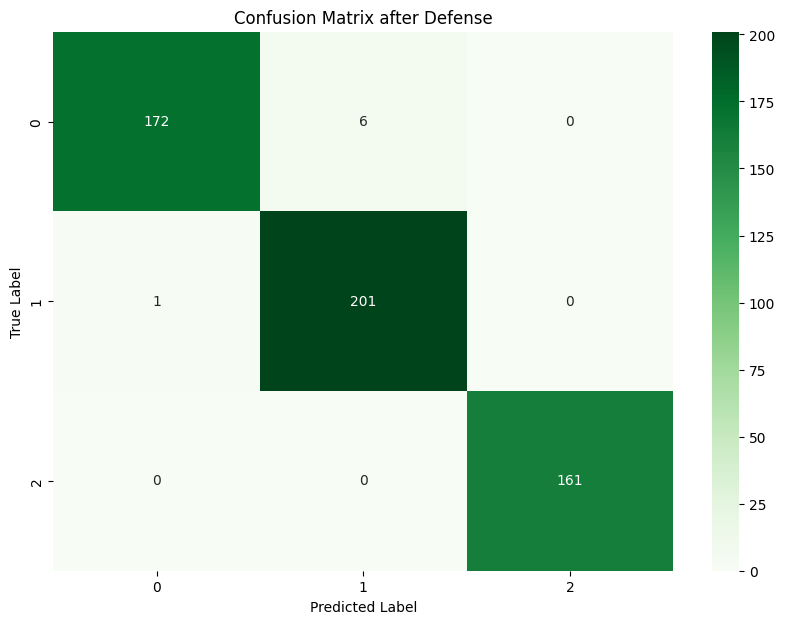

In [31]:
# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Log metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
print(f'Accuracy after defense: {accuracy_defended}')
print("Classification Report after defense:")
print(classification_report(y_test_np, y_pred_defended))

# Confusion Matrix for defended model
cm_defended = confusion_matrix(y_test_np, y_pred_defended)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_defended, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix after Defense')
plt.show()


In [32]:
from art.attacks.evasion import ZooAttack

# Set up the ZOO attack
attack = ZooAttack(
    classifier=art_model,
    confidence=0.5,
    targeted=False,
    learning_rate=1e-1,
    max_iter=1,
    binary_search_steps=1,
    initial_const=1e-1,
    abort_early=True,
    use_resize=False,
    use_importance=False,
    nb_parallel=1,
    batch_size=1,
    variable_h=0.01,
)


# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

# Retrain model with adversarial examples (if needed for defense)
X_train_combined = np.concatenate((X_train_np, X_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_np, y_pred_adv), axis=0)

model_defended = ExtraTreesClassifier()
model_defended.fit(X_train_combined, y_train_combined)

# Predict on the test set again
y_pred_defended = model_defended.predict(X_test_np)

# Metrics for the defended model
accuracy_defended = accuracy_score(y_test_np, y_pred_defended)
precision_defended, recall_defended, f1_defended, _ = precision_recall_fscore_support(y_test_np, y_pred_defended, average="weighted")
print(f"\nMetrics after defense:")
print(f"Accuracy: {accuracy_defended:.6f}")
print(f"Precision: {precision_defended:.6f}")
print(f"Recall: {recall_defended:.6f}")
print(f"F1-Score: {f1_defended:.6f}")
print(classification_report(y_test_np, y_pred_defended))

ZOO: 100%|█████████████████████████████████████████████| 541/541 [00:01<00:00, 310.49it/s]

Metrics after attack:
Accuracy: 0.981516
Precision: 0.982388
Recall: 0.981516
F1-Score: 0.981520
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       178
           1       0.95      1.00      0.98       202
           2       1.00      0.99      1.00       161

    accuracy                           0.98       541
   macro avg       0.98      0.98      0.98       541
weighted avg       0.98      0.98      0.98       541


Metrics after defense:
Accuracy: 0.983364
Precision: 0.984074
Recall: 0.983364
F1-Score: 0.983330
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       178
           1       0.96      1.00      0.98       202
           2       1.00      1.00      1.00       161

    accuracy                           0.98       541
   macro avg       0.99      0.98      0.98       541
weighted avg       0.98      0.98      0.98       541



In [33]:
from art.attacks.evasion import BoundaryAttack

# Set up the attack
attack = BoundaryAttack(
    estimator=art_model,
     targeted=False, max_iter=0, delta=0.001, epsilon=0.001
)


# Generate adversarial examples
X_test_adv = attack.generate(x=X_test_np)

# Predict on adversarial examples
y_pred_adv = model.predict(X_test_adv)

# Log metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
print(f'Accuracy after attack: {accuracy_adv}')
print(classification_report(y_test_np, y_pred_adv))



Boundary attack:   0%|                                            | 0/541 [00:00<?, ?it/s]
Boundary attack - iterations: 0it [00:00, ?it/s]
Boundary attack:   0%|▏                                   | 2/541 [00:00<00:41, 12.84it/s]
Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]
Boundary attack:   1%|▍                                   | 7/541 [00:00<00:21, 24.98it/s]
Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]
Boundary attack:   2%|▋                                  | 10/541 [00:00<00:26, 19.95it/s]
Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]
Boundary attack:   3%|▉                 

Accuracy after attack: 0.053604436229205174
              precision    recall  f1-score   support

           0       0.07      0.16      0.10       178
           1       0.00      0.00      0.00       202
           2       0.00      0.00      0.00       161

    accuracy                           0.05       541
   macro avg       0.02      0.05      0.03       541
weighted avg       0.02      0.05      0.03       541



In [34]:
# Metrics for the attacked model
accuracy_adv = accuracy_score(y_test_np, y_pred_adv)
precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_test_np, y_pred_adv, average="weighted")
print(f"Metrics after attack:")
print(f"Accuracy: {accuracy_adv:.6f}")
print(f"Precision: {precision_adv:.6f}")
print(f"Recall: {recall_adv:.6f}")
print(f"F1-Score: {f1_adv:.6f}")
print(classification_report(y_test_np, y_pred_adv))

Metrics after attack:
Accuracy: 0.053604
Precision: 0.024529
Recall: 0.053604
F1-Score: 0.033656
              precision    recall  f1-score   support

           0       0.07      0.16      0.10       178
           1       0.00      0.00      0.00       202
           2       0.00      0.00      0.00       161

    accuracy                           0.05       541
   macro avg       0.02      0.05      0.03       541
weighted avg       0.02      0.05      0.03       541



In [35]:
import numpy as np
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

# Set up the attack
attack = MembershipInferenceBlackBoxRuleBased(art_model)

# Infer membership
inferred_train = attack.infer(X_train, y_train)
inferred_test = attack.infer(X_test, y_test)

# Calculate accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
overall_acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))

print(f"Members Accuracy: {train_acc:.6f}")
print(f"Non Members Accuracy: {test_acc:.6f}")
print(f"Attack Accuracy: {overall_acc:.6f}")

# Define precision, recall, and F1-score function
def calc_precision_recall_f1(predicted, actual, positive_value=1):
    tp = np.sum((predicted == positive_value) & (actual == positive_value))  # True positives
    fp = np.sum((predicted == positive_value) & (actual != positive_value))  # False positives
    fn = np.sum((predicted != positive_value) & (actual == positive_value))  # False negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 1.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

# Prepare true labels (1 for train members, 0 for non-members)
true_labels = np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test))))
predicted_labels = np.concatenate((inferred_train, inferred_test))

# Calculate precision, recall, and F1-score
precision, recall, f1 = calc_precision_recall_f1(predicted_labels, true_labels)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")


Members Accuracy: 1.000000
Non Members Accuracy: 0.014787
Attack Accuracy: 0.704053
Precision: 0.702733
Recall: 1.000000
F1-Score: 0.825418


# Visualisations

/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_65223/2722014126.py:7: DtypeWarning: Columns (1,10,18,21,22,24,25,26,27,28,33,35,39,44,45,46,203,205,207) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


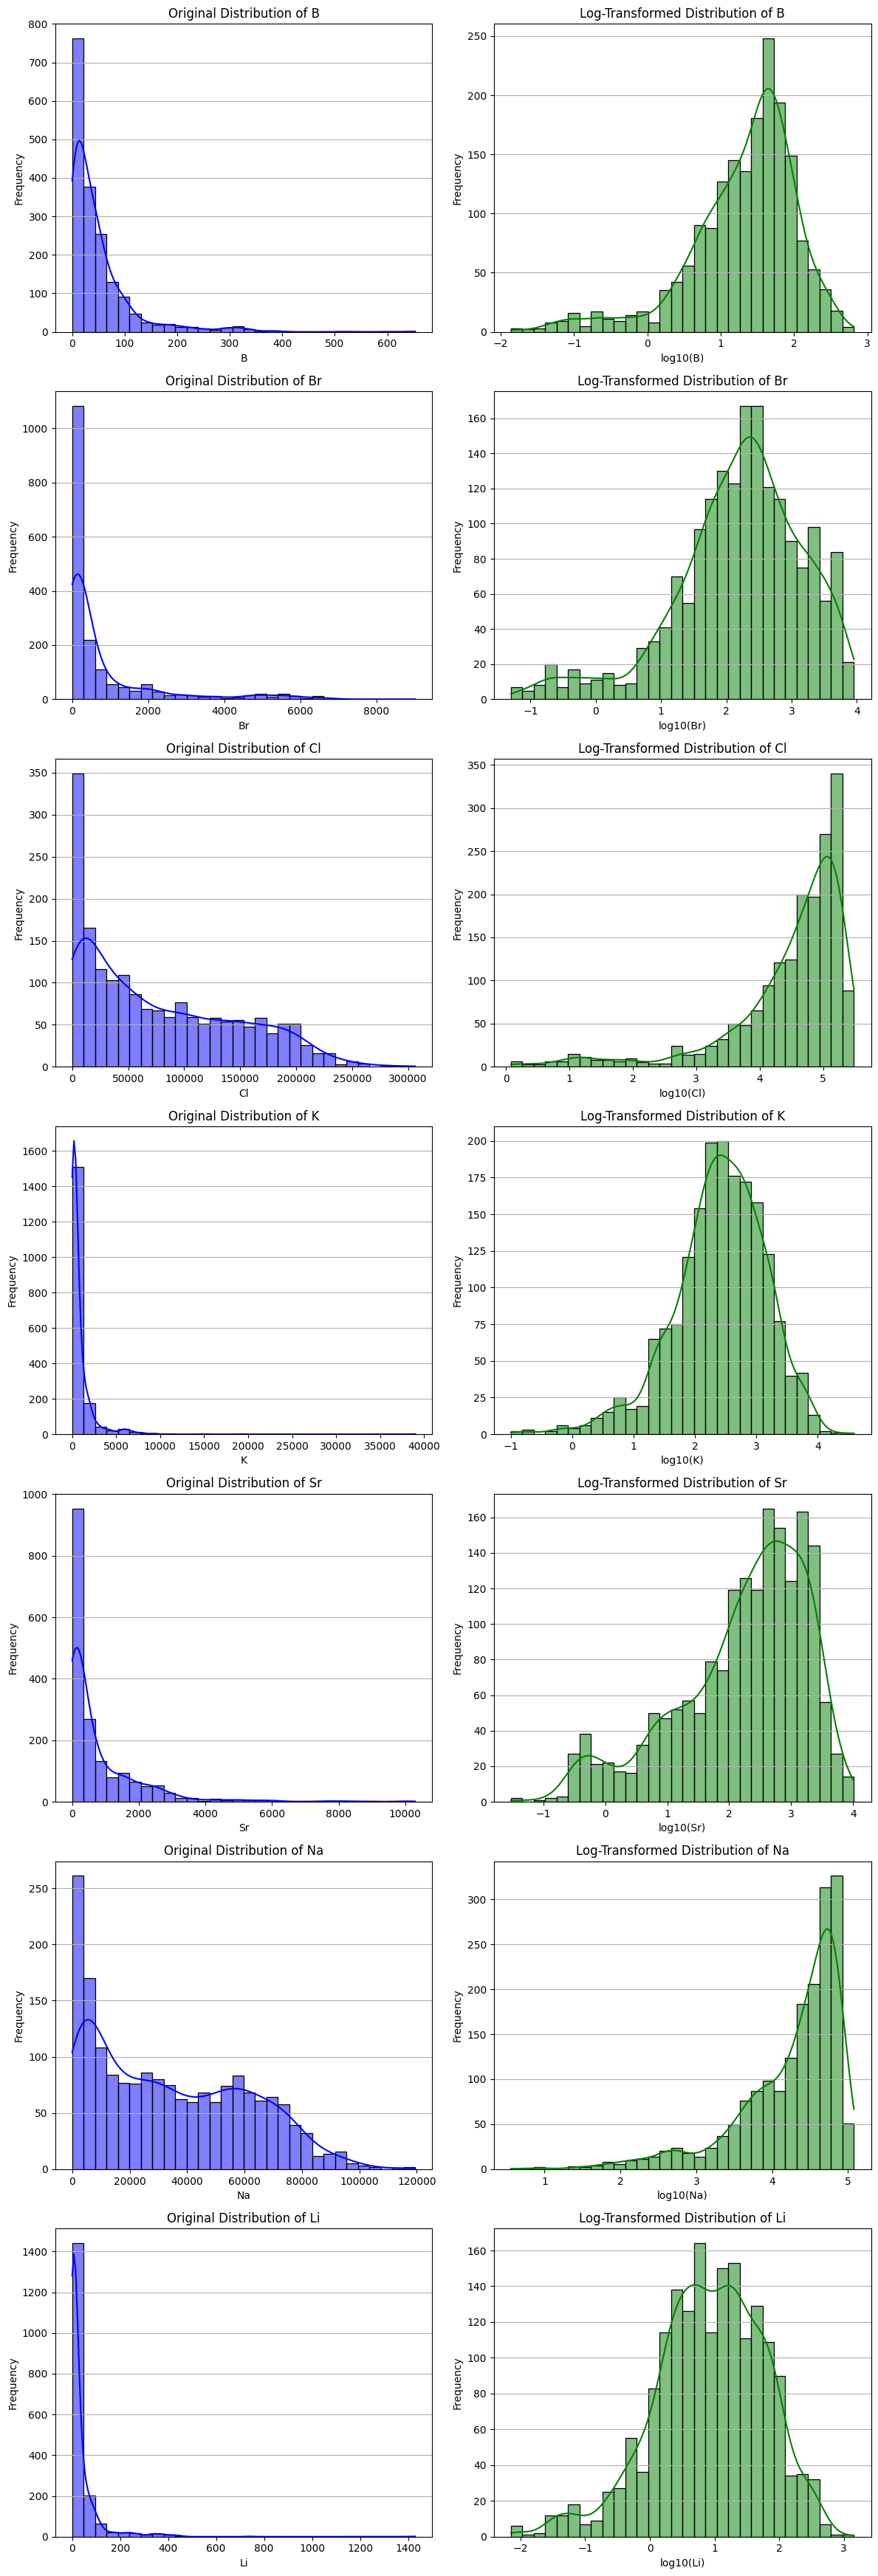

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

bins = [0, 700, 2000, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=False)

# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)

# Preserve the Na_class for later (it must stay based on the original 'Na' values)
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Na' and 'Na_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']].apply(np.log10)

# Reassign 'Na_class' back to the dataframe to keep it intact
df['Li_class'] = li_class

# Drop 'Na' column since it's no longer needed
# df = df.drop(columns='Li')
original_df = original_df.drop(columns=['Li_class'])

# Plot distributions side by side
fig, axes = plt.subplots(nrows=len(original_df.columns), ncols=2, figsize=(12, 5 * len(original_df.columns)))

for i, column in enumerate(original_df.columns):
    # Original feature distribution
    sns.histplot(original_df[column], kde=True, bins=30, color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'Original Distribution of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(axis='y')
    
    # Log-transformed feature distribution
    sns.histplot(df[column], kde=True, bins=30, color='green', ax=axes[i, 1])
    axes[i, 1].set_title(f'Log-Transformed Distribution of {column}')
    axes[i, 1].set_xlabel(f'log10({column})')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(axis='y')

plt.tight_layout()
plt.savefig('feature_distributions_comparison.png', dpi=300)
plt.show()


/var/folders/2l/q8wm67_x5yn9qtfylfw_gktc0000gn/T/ipykernel_65223/534798299.py:7: DtypeWarning: Columns (1,10,18,21,22,24,25,26,27,28,33,35,39,44,45,46,203,205,207) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


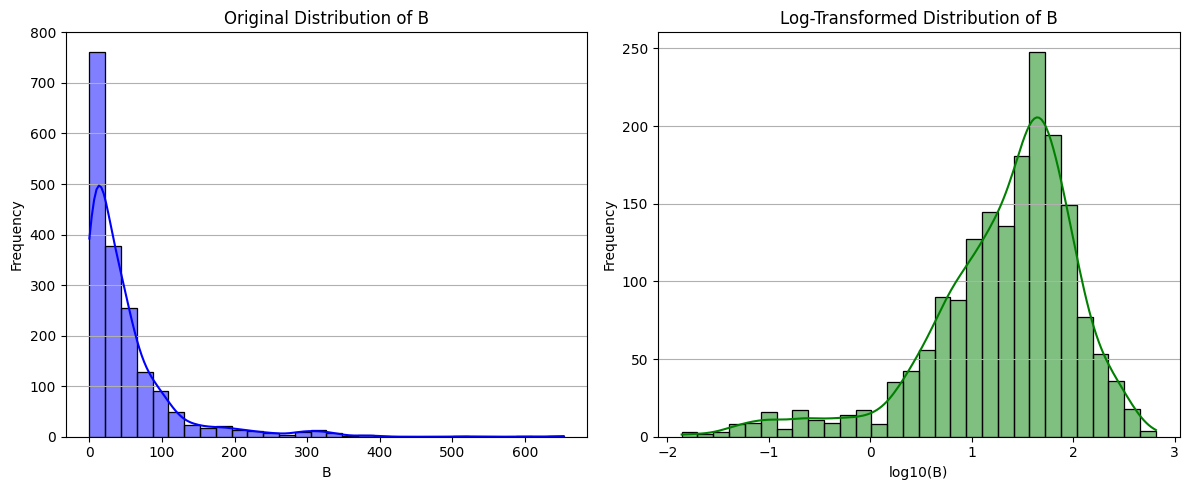

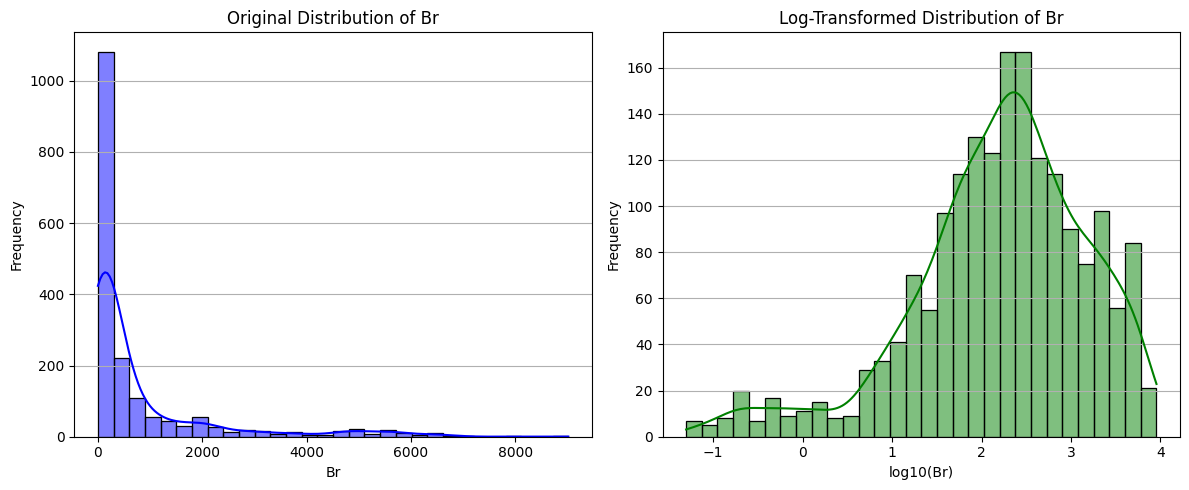

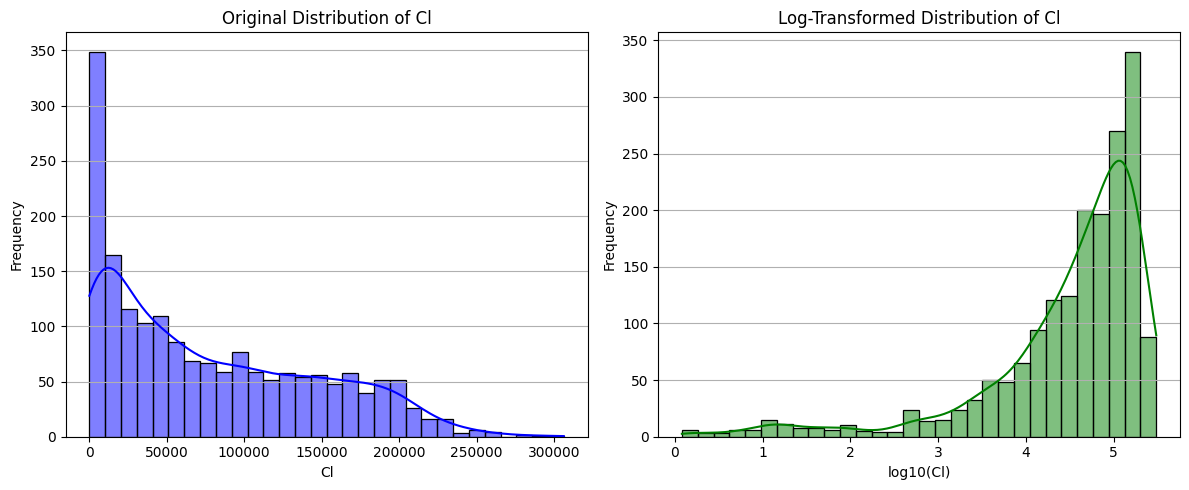

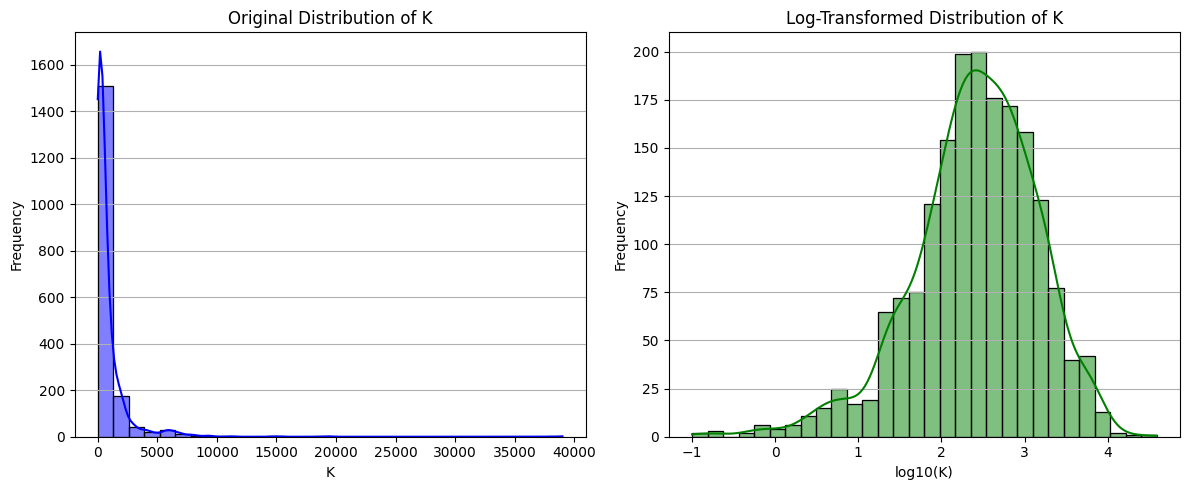

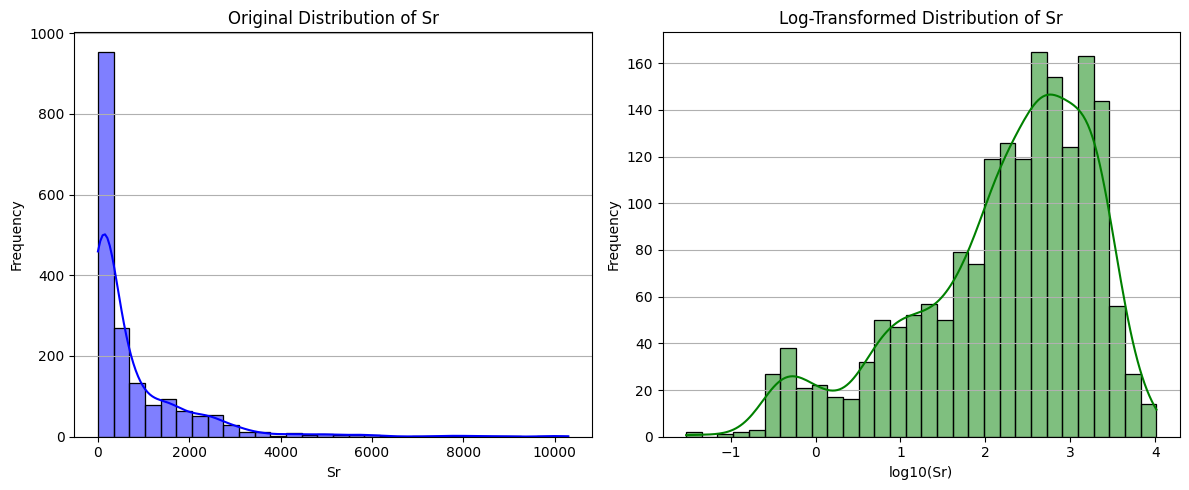

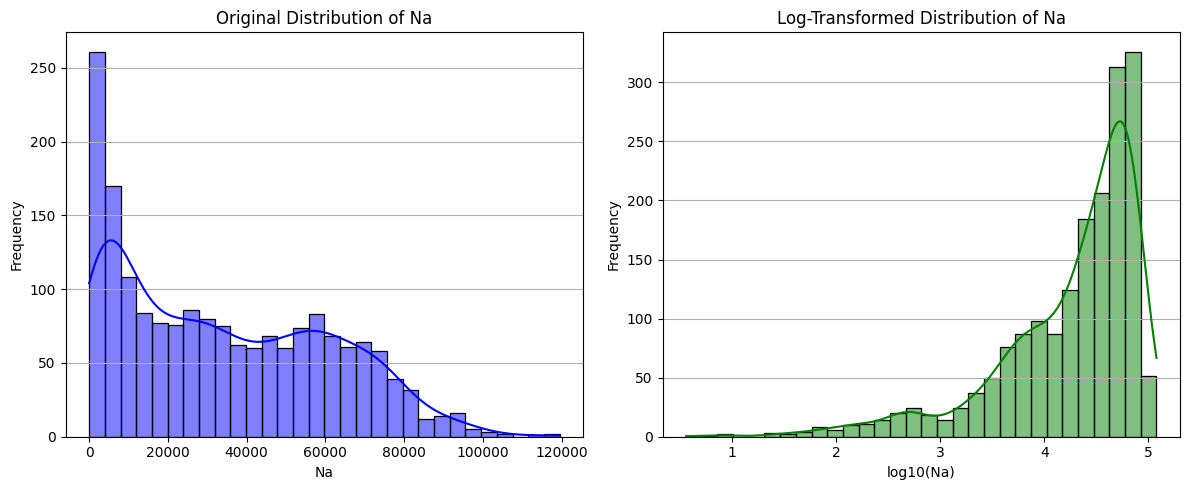

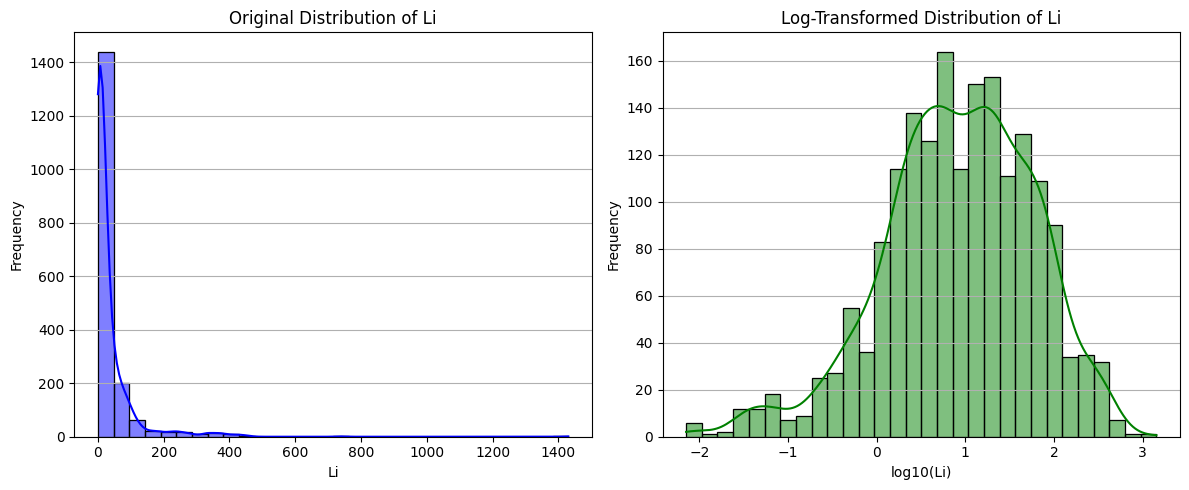

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data.csv')
# Select relevant columns
df = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']]

# Data preprocessing
# Drop rows with any NaN values
df = df.dropna(axis=0, how='any')

bins = [0, 700, 2000, float('inf')]
labels = ['low', 'medium', 'high']
df['Li_class'] = pd.cut(df['Li'], bins=bins, labels=labels, right=False)

# Map class labels to integers
df['Li_class'] = df['Li_class'].map({'low': 0, 'medium': 1, 'high': 2}).astype(int)

# Preserve the Li_class for later
li_class = df['Li_class'].copy()

# Store original data before log transformation
original_df = df.copy()

# Apply log transformation to the features (except 'Na' and 'Li_class')
df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']] = df[['B', 'Br', 'Cl', 'K', 'Sr', 'Na', 'Li']].apply(np.log10)

# Reassign 'Li_class' back to the dataframe
df['Li_class'] = li_class

# Drop 'Li_class' from the original copy to only keep numeric columns for plotting
original_df = original_df.drop(columns=['Li_class'])

# Create separate figures for each column
for column in original_df.columns:
    # Create a new figure for each feature
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Original feature distribution
    sns.histplot(original_df[column], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f'Original Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y')

    # Log-transformed feature distribution
    sns.histplot(df[column], kde=True, bins=30, color='green', ax=axes[1])
    axes[1].set_title(f'Log-Transformed Distribution of {column}')
    axes[1].set_xlabel(f'log10({column})')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.savefig(f'cwd/fd{column}.png', dpi=300)
    plt.show()
